<a href="https://colab.research.google.com/github/songaong8006/Intern_fastai/blob/main/shoes_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 5.0MB/s 
     |████████████████████████████████| 1.2MB 8.8MB/s 
     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 194kB 21.4MB/s 
     |████████████████████████████████| 61kB 4.9MB/s 
Mounted at /content/gdrive


In [3]:
from fastbook import *
from fastai.vision.widgets import *

In [4]:
key = os.environ.get('AZURE_SEARCH_KEY', 'cde11e5586cb4e9e9f52586c2403588e')

In [5]:
search_images_bing

<function fastbook.search_images_bing>

In [6]:
results = search_images_bing(key, 'nike')
ims = results.attrgot('content_url')
len(ims)

150

In [11]:
ims = ['https://static.nike.com/a/images/t_PDP_1280_v1/f_auto,q_auto:eco/uoxteud0rv2d2wml9xkl/air-force-1-07-mens-shoe-TjqcX1.jpg']
ims

['https://static.nike.com/a/images/t_PDP_1280_v1/f_auto,q_auto:eco/uoxteud0rv2d2wml9xkl/air-force-1-07-mens-shoe-TjqcX1.jpg']

In [15]:
import os
os.mkdir('images')

FileExistsError: ignored

In [16]:
dest = 'images/nike.jpg'
download_url(ims[0], dest)

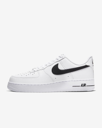

In [17]:
im = Image.open(dest)
im.to_thumb(128,128)

In [18]:
shoes_types = 'nike','adidas','reebok'
path = Path('shoes')

In [19]:
if not path.exists():
    path.mkdir()
    for o in shoes_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} shoes')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [20]:
fns = get_image_files(path)
fns

(#423) [Path('shoes/adidas/00000138.jpg'),Path('shoes/adidas/00000041.jpg'),Path('shoes/adidas/00000125.jpg'),Path('shoes/adidas/00000040.jpg'),Path('shoes/adidas/00000016.jpg'),Path('shoes/adidas/00000024.jpg'),Path('shoes/adidas/00000051.jpg'),Path('shoes/adidas/00000046.JPG'),Path('shoes/adidas/00000063.jpg'),Path('shoes/adidas/00000106.jpg')...]

In [21]:
failed = verify_images(fns)
failed

(#15) [Path('shoes/adidas/00000121.jpg'),Path('shoes/adidas/00000082.jpg'),Path('shoes/adidas/00000065.jpg'),Path('shoes/adidas/00000149.jpg'),Path('shoes/adidas/00000088.jpg'),Path('shoes/adidas/00000004.jpg'),Path('shoes/nike/00000051.jpg'),Path('shoes/nike/00000042.jpg'),Path('shoes/nike/00000030.jpg'),Path('shoes/nike/00000007.jpg')...]

In [22]:
failed.map(Path.unlink);

In [23]:
shoes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [24]:
dls = shoes.dataloaders(path)

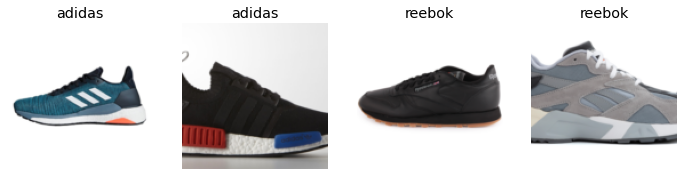

In [25]:
dls.valid.show_batch(max_n=4, nrows=1)

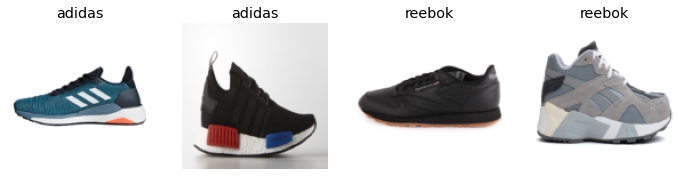

In [26]:
shoes = shoes.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = shoes.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

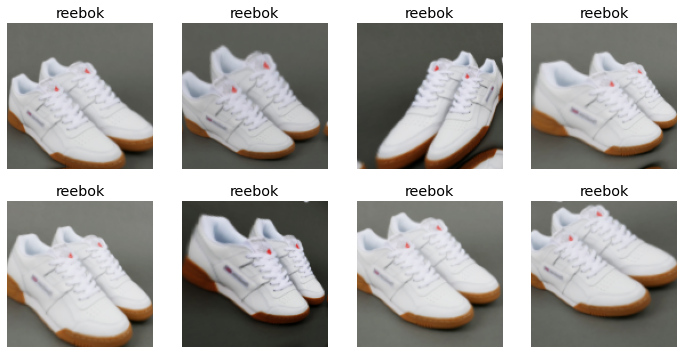

In [27]:
shoes = shoes.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = shoes.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [28]:
shoes = shoes.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = shoes.dataloaders(path)

In [29]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.928333,1.381549,0.543210,01:28


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,1.273572,0.950234,0.407407,01:54
1,1.081542,0.720203,0.283951,01:53
2,0.895397,0.714526,0.234568,01:53
3,0.802434,0.730830,0.234568,01:54


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


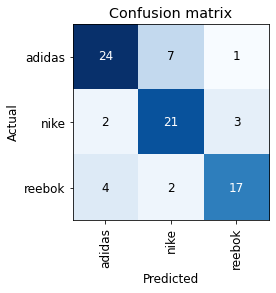

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

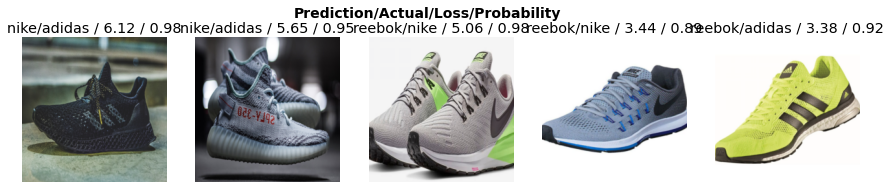

In [31]:
interp.plot_top_losses(5, nrows=1)

In [32]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [34]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

FileNotFoundError: ignored

In [35]:
learn.export()

In [36]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [37]:
learn_inf = load_learner(path/'export.pkl')

In [38]:
learn_inf.predict('images/nike.jpg')

('nike', tensor(1), tensor([0.1403, 0.8587, 0.0011]))

In [40]:
learn_inf.dls.vocab

['adidas', 'nike', 'reebok']

In [41]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [43]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/nike.jpg'])

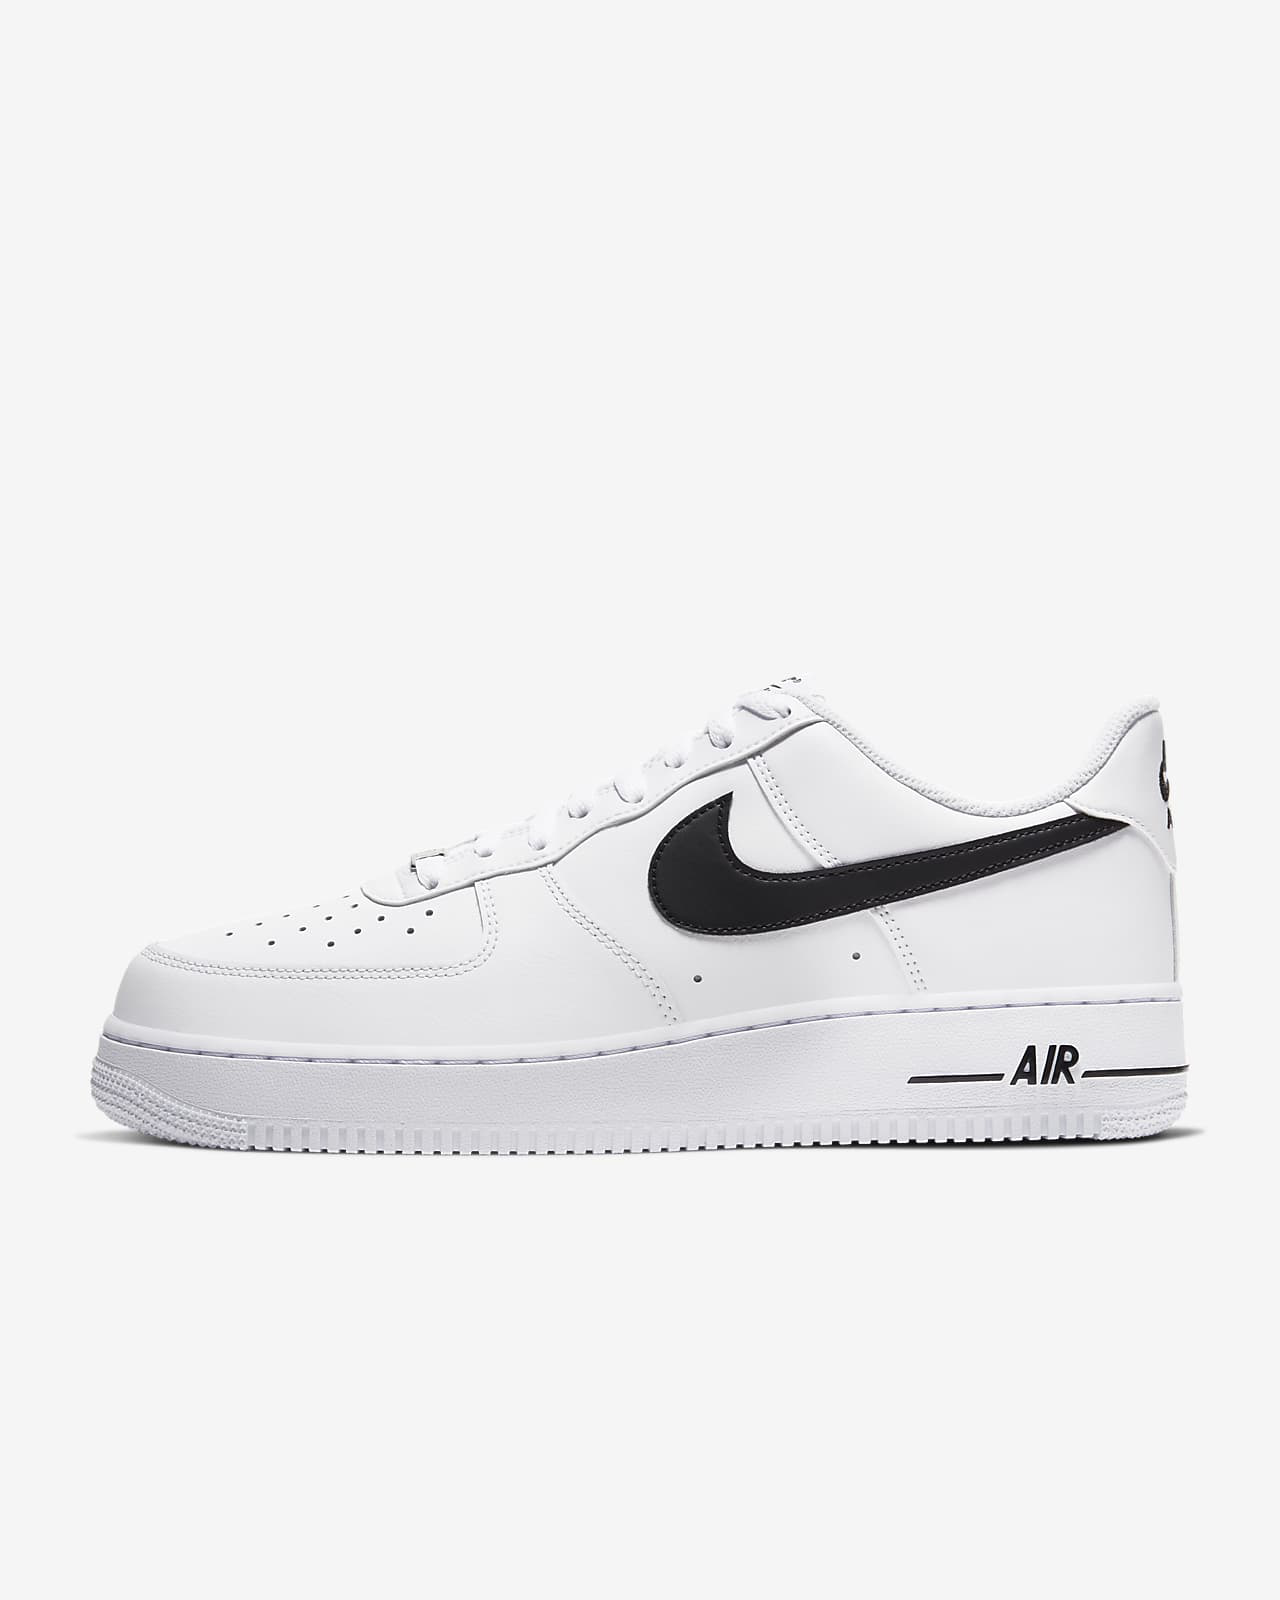

In [45]:
img = PILImage.create(btn_upload.data[-1])
img

In [61]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
out_pl

Output()

In [ ]:
with out_pl: display(img.to_thumb(128,128))

In [62]:
pred,pred_idx,probs = learn_inf.predict(img)

In [63]:
lbl_pred = widgets.Label()
lbl_pred.value = 'Please choose an image'
lbl_pred

Label(value='Please choose an image')

In [64]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [65]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [66]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [67]:
#hide_output
VBox([widgets.Label('Select your shoes!'), 
      btn_upload, btn_run, out_pl, lbl_pred])